In [31]:
import tensorflow as tf
import io
from PIL import Image
import cv2
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.applications.imagenet_utils import decode_predictions
from tensorflow.keras import backend as K

import ipywidgets as widgets
from IPython.display import display, Javascript, HTML, clear_output, IFrame
from ipywidgets import interact, interactive, fixed, interact_manual, AppLayout, GridspecLayout
import matplotlib.pyplot as plt

from src.utils import model_dicts, array2bytes, create_model, get_conv_layers
from src.guidedBacprop import GuidedBackprop, deprocess_image
from src.gradcam import GradCAM, overlay_gradCAM
from src.filtersVis import extract_filter, vis_filter
from src.featuresVis import FeaturesExtraction, vis_feature_map

In [32]:
def create_expanded_button(description, button_style):
    return widgets.Button(description=description, button_style=button_style,
                          layout=widgets.Layout(height='auto', width='auto'))

model_ls = ["--Select"] + list(model_dicts.keys())
layer_ls = ["--Select"]
method_ls = ["--Select","Filter vis", "Feature map vis","Guided Backprop"]
class_ls = ["--Select"]

uploader = widgets.FileUpload()
show_but = create_expanded_button("Show image","success")
header = widgets.HTML('<font color="#1f77b4" face="sans-serif"><center><h1>Visualize and Explain Networks</h1><h3>All pre-trained models (Keras) on ImageNet</h3><hr style="height:2px;border-width:0;color:gray;background-color:gray"></center></font>',
                      layout=widgets.Layout(height='auto'))
models = widgets.Dropdown(options=model_ls, description="Model: ", layout={"width":"auto"},disabled=False)
layers = widgets.Dropdown(options=layer_ls, description="Layer: ", layout={"width":"auto"},disabled=False)
vis_but = create_expanded_button("Visualize","info")
methods = widgets.Dropdown(options=method_ls, description="Vis method: ", layout={"width":"auto"},disabled=False)
explain_but = create_expanded_button("Predict & Explain","warning")
classes = widgets.Dropdown(options=class_ls, description="Vis class: ", layout={"width":"auto"},disabled=False)
deep_dream_but = create_expanded_button("Generate","primary")
deco = widgets.Image(
    value=open("images/lapan.jpg","rb").read(),
    format="jpg",
    width="auto",
    height="auto",
    align="center-align"
)

GridspecLayout(children=(FileUpload(value={'gau-816x1020.jpg': {'metadata': {'name': 'gau-816x1020.jpg', 'type…

Guided Backpropagation from layer block14_sepconv2


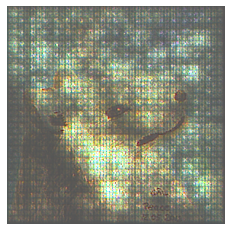

In [34]:
# Layout
grid = GridspecLayout(15,30,height="600px")
grid[0,:4] = uploader
grid[0,5:9] = show_but
grid[0:3,10:] = header
grid[2,:9] = models
grid[3,:9] = widgets.HTML('<hr style="height:2px;border-width:0;color:gray;background-color:gray"><font color="gray" face="sans-serif"><center><h4>Filter and Feature Map Vis</h4></center>')
grid[4,:9] = layers
grid[5,:9] = methods
grid[7,:9] = vis_but
grid[8,:9] = widgets.HTML('<hr style="height:2px;border-width:0;color:gray;background-color:gray"><font color="gray" face="sans-serif"><center><h4>Explanation</h4></center>')
grid[9,:9] = explain_but
grid[11,:9] = classes
grid[13,:9] = widgets.HTML('<hr style="height:2px;border-width:0;color:gray;background-color:gray"><font color="gray" face="sans-serif"><center><h4>Deep Dream</h4></center>')
grid[14,:9] = deep_dream_but
grid[4:12,10:] = deco
grid[14,10:] = widgets.HTML('<font color="gray" face="sans-serif"><center><h4>Lang Co, Hue, Vietnam</h4></center>')
display(grid)

def on_change_model(change):
    if change["type"] == "change" and change["name"] == "value":
        chosen_model = change["new"]
        if chosen_model == "--Select":
            layer_ls = ["--Select"]
        else:
            model = create_model(chosen_model)
            layers.options = get_conv_layers(model)
        
    
def show_button(sender):
    for _, file_info in uploader.value.items():
        image = Image.open(io.BytesIO(file_info['content']))
        
    img = np.array(image)
    image.close()
    uploaded_img = widgets.Image(value=array2bytes(img))
    grid[4:10,10:] = uploaded_img
    
def vis_button(sender):
    clear_output()
    display(grid)
    model_name = models.value
    model = create_model(model_name)
    layer_name = layers.value
    assert methods.value in method_ls, "Method must be in {}".format(method_ls)
    if methods.value == "Filter vis":
        filters = extract_filter(model=model,layer_name=layer_name)
        print("Visualize filters {} of {}".format(layer_name, model_name))
        print("Filter shape: {}".format(filters.shape))
        print("Visualize 3 first channels of max 6 first filters:")
        vis_filter(filters)
    else:
        for _, file_info in uploader.value.items():
            image = Image.open(io.BytesIO(file_info['content']))
        
        img = np.array(image)
        target_size = (model.input.shape[1], model.input.shape[2])
        preprocess_input = getattr(getattr(tf.keras.applications,model_dicts[model_name]),"preprocess_input")
        img = cv2.resize(img,target_size)
        processed_img = preprocess_input(img)
        
        if methods.value == "Feature map vis":
            feature_extract = FeaturesExtraction(model,layer_name)
            feature_maps = feature_extract.extract_features(np.expand_dims(processed_img,axis=0))
            print("Feature map shape: {}. Visualize maximum 64 feature maps.".format(feature_maps.shape))
            vis_feature_map(feature_maps)
        if methods.value == "Guided Backprop":
            guidedBP = GuidedBackprop(model=model,layerName=layer_name)
            gb_cam = guidedBP.guided_backprop(np.expand_dims(img,axis=0),target_size)
            gb_im = deprocess_image(gb_cam)
            gb_im = cv2.cvtColor(gb_im, cv2.COLOR_BGR2RGB)
            print("Guided Backpropagation from layer {}".format(layer_name))
            plt.imshow(gb_im)
            plt.axis("off")
    
show_but.on_click(show_button)
models.observe(on_change_model)
vis_but.on_click(vis_button)

In [7]:
len(model_dicts)

26

In [14]:
im = cv2.imread("images/lapan.jpg")

In [10]:
model = create_model("VGG16")

In [15]:
target_size = (model.input.shape[1], model.input.shape[2])
target_size

(224, 224)

In [16]:
preprocess_input = getattr(getattr(tf.keras.applications,model_dicts["DenseNet121"]),"preprocess_input")

In [17]:
img = cv2.resize(im,target_size)
img = preprocess_input(img)

In [13]:
deconvNet = DeConvNet(model)

In [19]:
deconv_cam = deconvNet.deconv_backprop(np.expand_dims(img,axis=0),target_size)

In [20]:
deconv_im = deprocess_image(deconv_cam)

In [21]:
deconv_im = cv2.cvtColor(deconv_im, cv2.COLOR_BGR2RGB)

In [22]:
widgets.Image(
    value=array2bytes(deconv_im),
    format='png',
    width='auto',
    height='auto',
    align="center-align"
)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xe0\x00\x00\x00\xe0\x08\x02\x00\x00\x00\x95O\xfd…